<h1>
Exercício 4
</h1>
<h2>
Vamos tentar criar um modelo temporal para prever o valor aprovado de crédito para um dia futuro.
</h2>

# Bibliotecas

In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [38]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i+look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()
    
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100    

<h1>
Carregando os dados iniciais
</h1>
<h2>
Para este exercício vamos carregar a base original pois iremos trabalhar apenas com as variáveis: valor aprovado e datas de aprovação.
</h2>

In [39]:
df = pd.read_csv("solicitacoescredito.csv")
df.head()

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.0,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.0,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,...,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.0,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.0,89000.0,2020-02-04T15:06:28


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8973 entries, 0 to 8972
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           8973 non-null   int64  
 1   razaoSocial                  8973 non-null   object 
 2   nomeFantasia                 8973 non-null   object 
 3   cnpjSemTraco                 8973 non-null   object 
 4   maiorAtraso                  8973 non-null   int64  
 5   margemBrutaAcumulada         8973 non-null   float64
 6   percentualProtestos          7475 non-null   float64
 7   primeiraCompra               8867 non-null   object 
 8   prazoMedioRecebimentoVendas  8973 non-null   int64  
 9   titulosEmAberto              8973 non-null   float64
 10  valorSolicitado              8973 non-null   float64
 11  status                       8973 non-null   object 
 12  definicaoRisco               8973 non-null   object 
 13  diferencaPercentua

<h2>
Abaixo vamos reduzir a base para ficar apenas com a data em que cada crédito foi aprovado e o seu valor.
</h2>

In [41]:
df_temporal = df[['dataAprovadoNivelAnalista', 'dataAprovadoEmComite', 'valorAprovado']]
df_temporal['dataAprovadoEmComite'].fillna(df_temporal['dataAprovadoNivelAnalista'], inplace=True)
df_temporal.drop('dataAprovadoNivelAnalista', axis=1, inplace=True)
df_temporal.rename({'dataAprovadoEmComite': 'data', 'valorAprovado': 'valor'}, axis=1, inplace=True)
df_temporal.dropna(inplace=True)
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7569 entries, 0 to 8961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    7569 non-null   object 
 1   valor   7569 non-null   float64
dtypes: float64(1), object(1)
memory usage: 177.4+ KB


<h2>
Ajustamos a data para retirar os horários e ficar apenas com os dias.
</h2>

In [42]:
df_temporal.data = [x[:-9] for x in df_temporal.data]
df_temporal.valor = df_temporal.valor.astype('int64')
df_temporal

,data,valor
0,2020-02-03,50000
2,2020-02-04,20000
3,2020-02-04,15000
4,2020-02-04,50000
5,2020-02-04,20000
...,...,...
8956,2021-02-25,45000
8957,2021-02-25,15000
8958,2021-02-25,1500000
8960,2021-02-25,20000


<h2>
Verificando a presença de Extremos (Outliers) no campor valor
</h2>

In [43]:
perc = str(round(percentual_outlier(df_temporal.valor), 2))
print(f'Extremos em valor : {perc}%')

Extremos em valor : 15.52%


<h2>
Possuímos um valor elevado de extremos que irão dificultar o LSTM.<BR>
Vamos retirá-los,
</h2>

In [44]:
data = df_temporal.valor

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
minimum = Q1 - (1.5 * IQR)
maximum = Q3 + (1.5 * IQR)

outliers = ((data < minimum) | (data > maximum))
df_temporal.valor.loc[outliers] = np.nan

df_temporal.dropna(inplace=True)    

<h2>
Precisamos agrupar os dias iguais, somando os valores para termos um total por dia.
</h2>

In [45]:
df_temporal_agrupado = df_temporal.groupby('data', as_index=False).sum()
df_temporal_agrupado.sort_values('data', inplace=True)
df_temporal_agrupado

,data,valor
0,2020-02-03,50000.0
1,2020-02-04,105000.0
2,2020-02-05,702000.0
3,2020-02-06,1295000.0
4,2020-02-07,2055000.0
...,...,...
255,2021-02-19,951900.0
256,2021-02-22,832000.0
257,2021-02-23,816500.0
258,2021-02-24,1605000.0


<h2>
Ao agurupar os dias percebemos que não estão contínuos. Existem diversas falhas na seguência e nem todas podem ser explicadas por final de semana ou feriado.<BR>
Decidimos então criar uma base com todos os dias e unir as duas.
</h2>

In [46]:
df_base_dias = pd.date_range(start='2020-02-03', end='2021-02-25')
df_base_dias = df_base_dias.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
df_base_dias = pd.DataFrame(df_base_dias, columns=['data'])
df_base_dias

,data
0,2020-02-03
1,2020-02-04
2,2020-02-05
3,2020-02-06
4,2020-02-07
...,...
384,2021-02-21
385,2021-02-22
386,2021-02-23
387,2021-02-24


In [49]:
df_temporal = pd.merge(df_base_dias, df_temporal_agrupado, how='left')
df_temporal.data = df_temporal.index + 1
df_temporal.rename({'data': 'dia'}, axis=1, inplace=True)
df_temporal

,dia,valor
0,1,50000.0
1,2,105000.0
2,3,702000.0
3,4,1295000.0
4,5,2055000.0
...,...,...
384,385,NaN
385,386,832000.0
386,387,816500.0
387,388,1605000.0


<h2>
Agora temos os dados faltantes que iremos preencher com um KNNInputer.<BR>
Este método vais usar a média entre os K vizinhos.
</h2>

In [50]:
df_temporal.isnull().sum()

dia        0
valor    129
dtype: int64

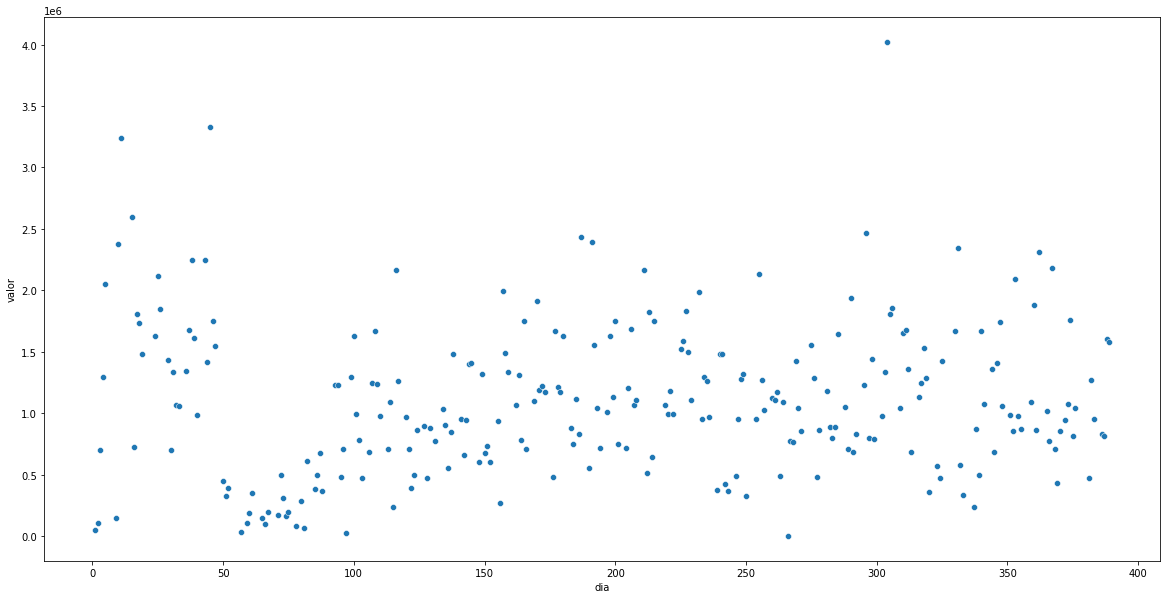

In [51]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=df_temporal.dia, y=df_temporal.valor)
plt.show()

In [61]:
imputer = KNNImputer(n_neighbors=4)
knn = imputer.fit_transform(df_temporal)
knn = knn.astype('int64')
knn

array([[      1,   50000],
       [      2,  105000],
       [      3,  702000],
       [      4, 1295000],
       [      5, 2055000],
       [      6, 1049625],
       [      7, 1468625],
       [      8, 1955625],
       [      9,  146500],
       [     10, 2378000],
       [     11, 3243000],
       [     12, 2091375],
       [     13, 2235250],
       [     14, 2092350],
       [     15, 2598000],
       [     16,  722000],
       [     17, 1806400],
       [     18, 1737800],
       [     19, 1480000],
       [     20, 1662925],
       [     21, 1662925],
       [     22, 1768775],
       [     23, 1768775],
       [     24, 1627500],
       [     25, 2116400],
       [     26, 1851200],
       [     27, 1757775],
       [     28, 1526900],
       [     29, 1436000],
       [     30,  704000],
       [     31, 1333000],
       [     32, 1065000],
       [     33, 1056950],
       [     34, 1199987],
       [     35, 1581062],
       [     36, 1345000],
       [     37, 1678500],
 

In [62]:
df_dias = pd.DataFrame(knn[:,1], columns=['valor'])
df_dias

,valor
0,50000
1,105000
2,702000
3,1295000
4,2055000
...,...
384,966975
385,832000
386,816500
387,1605000


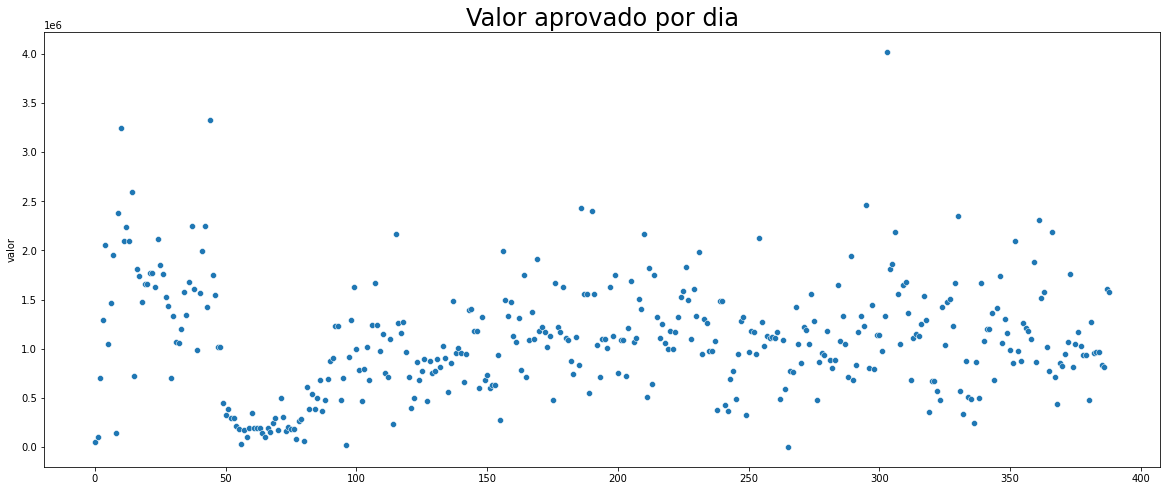

In [63]:
fig = plt.figure(figsize=(20,8))
sns.scatterplot(x=df_dias.index, y=df_dias.valor)
plt.title('Valor aprovado por dia', size=24)
plt.show()

<AxesSubplot:ylabel='Count'>

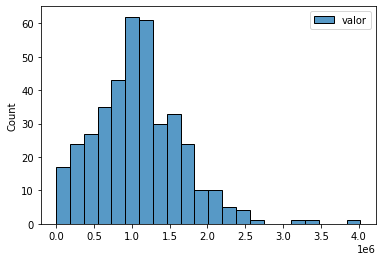

In [64]:
sns.histplot(df_dias)

In [65]:
df_dias.describe()

,valor
count,3.890000e+02
mean,1.084995e+06
std,5.681374e+05
min,1.000000e+01
25%,7.100000e+05
50%,1.065000e+06
75%,1.400875e+06
max,4.022000e+06


<h1>Modelo LSTM</h1>

<h2>
Previsão por Dias
</h2>

In [81]:
X = np.array(df_dias.valor)
X = X.astype('float32').reshape(-1,1)

In [82]:
X.shape

(389, 1)

In [83]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [84]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

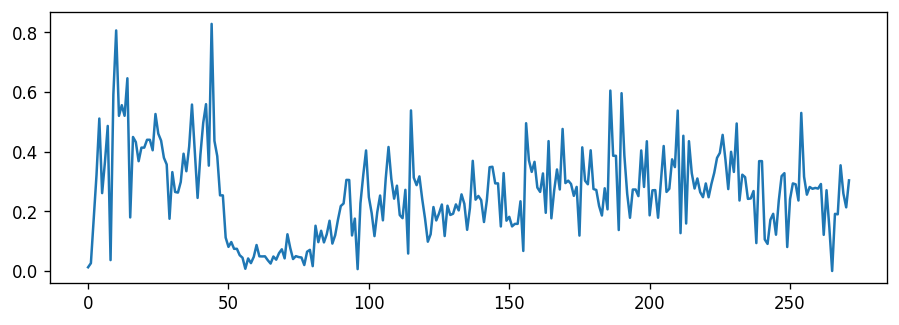

In [85]:
plt.plot(train)

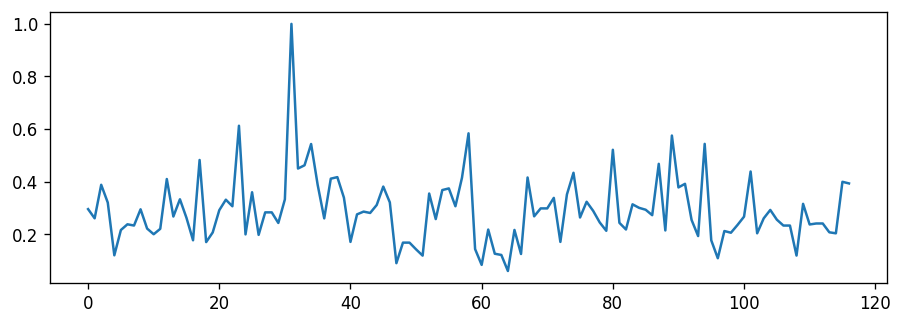

In [86]:
plt.plot(test)

In [87]:
best = 0
best_mse = np.Infinity
for n in range(1, 101, 5):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(256, input_shape=(look_back, 1), dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

look back 1 - 0.01633610762655735 | best 1 - 0.01633610762655735
look back 6 - 0.01635332778096199 | best 1 - 0.01633610762655735
look back 11 - 0.01717221364378929 | best 1 - 0.01633610762655735
look back 16 - 0.01771950162947178 | best 1 - 0.01633610762655735
look back 21 - 0.017851797863841057 | best 1 - 0.01633610762655735
look back 26 - 0.017252132296562195 | best 1 - 0.01633610762655735
look back 31 - 0.018060753121972084 | best 1 - 0.01633610762655735
look back 36 - 0.012351132929325104 | best 36 - 0.012351132929325104
look back 41 - 0.012404325418174267 | best 36 - 0.012351132929325104
look back 46 - 0.013182921335101128 | best 36 - 0.012351132929325104
look back 51 - 0.012815198861062527 | best 36 - 0.012351132929325104
look back 56 - 0.013342923484742641 | best 36 - 0.012351132929325104
look back 61 - 0.011201519519090652 | best 61 - 0.011201519519090652
look back 66 - 0.010715346783399582 | best 66 - 0.010715346783399582
look back 71 - 0.010863695293664932 | best 66 - 0.0107

In [88]:
best = 0
best_mse = np.Infinity
for n in range(101, 121, 5):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(256, input_shape=(look_back, 1), dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

look back 101 - 0.0058865975588560104 | best 101 - 0.0058865975588560104
look back 106 - 0.0050068204291164875 | best 106 - 0.0050068204291164875
look back 111 - 0.0053285276517271996 | best 106 - 0.0050068204291164875


IndexError: tuple index out of range

In [121]:
# quantidade de atrasos
look_back = 66

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [122]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [123]:
X_train.shape

(205, 66, 1)

In [124]:
y_train.shape

(205,)

# Modelo LSTM

In [125]:
model = Sequential()
model.add(LSTM(64, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [126]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [127]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

Epoch 1/100
192/205 [===========================>..] - ETA: 0s - loss: 0.0115
Epoch 00001: val_loss improved from inf to 0.01229, saving model to .\modelo_lstm_ex4.hdf5
205/205 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0123
Epoch 2/100
196/205 [===========================>..] - ETA: 0s - loss: 0.0123
Epoch 00002: val_loss improved from 0.01229 to 0.01166, saving model to .\modelo_lstm_ex4.hdf5
205/205 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 3/100
198/205 [===========================>..] - ETA: 0s - loss: 0.0114
Epoch 00003: val_loss did not improve from 0.01166
205/205 [==============================] - 1s 4ms/step - loss: 0.0112 - val_loss: 0.0119
Epoch 4/100
194/205 [===========================>..] - ETA: 0s - loss: 0.0116
Epoch 00004: val_loss did not improve from 0.01166
205/205 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 5/100
203/205 [=======================

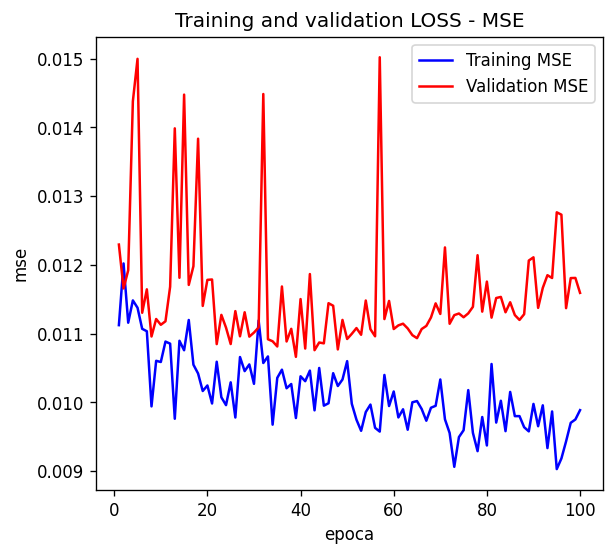

In [128]:
plot_history(history)

In [129]:
model = load_model("./modelo_lstm_ex4.hdf5")

In [130]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [131]:
trainPredict.shape

(205, 1)

In [132]:
y_train.shape

(205,)

In [133]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [134]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 416495.17 RMSE
Test Score: 415289.48 RMSE


In [135]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [136]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

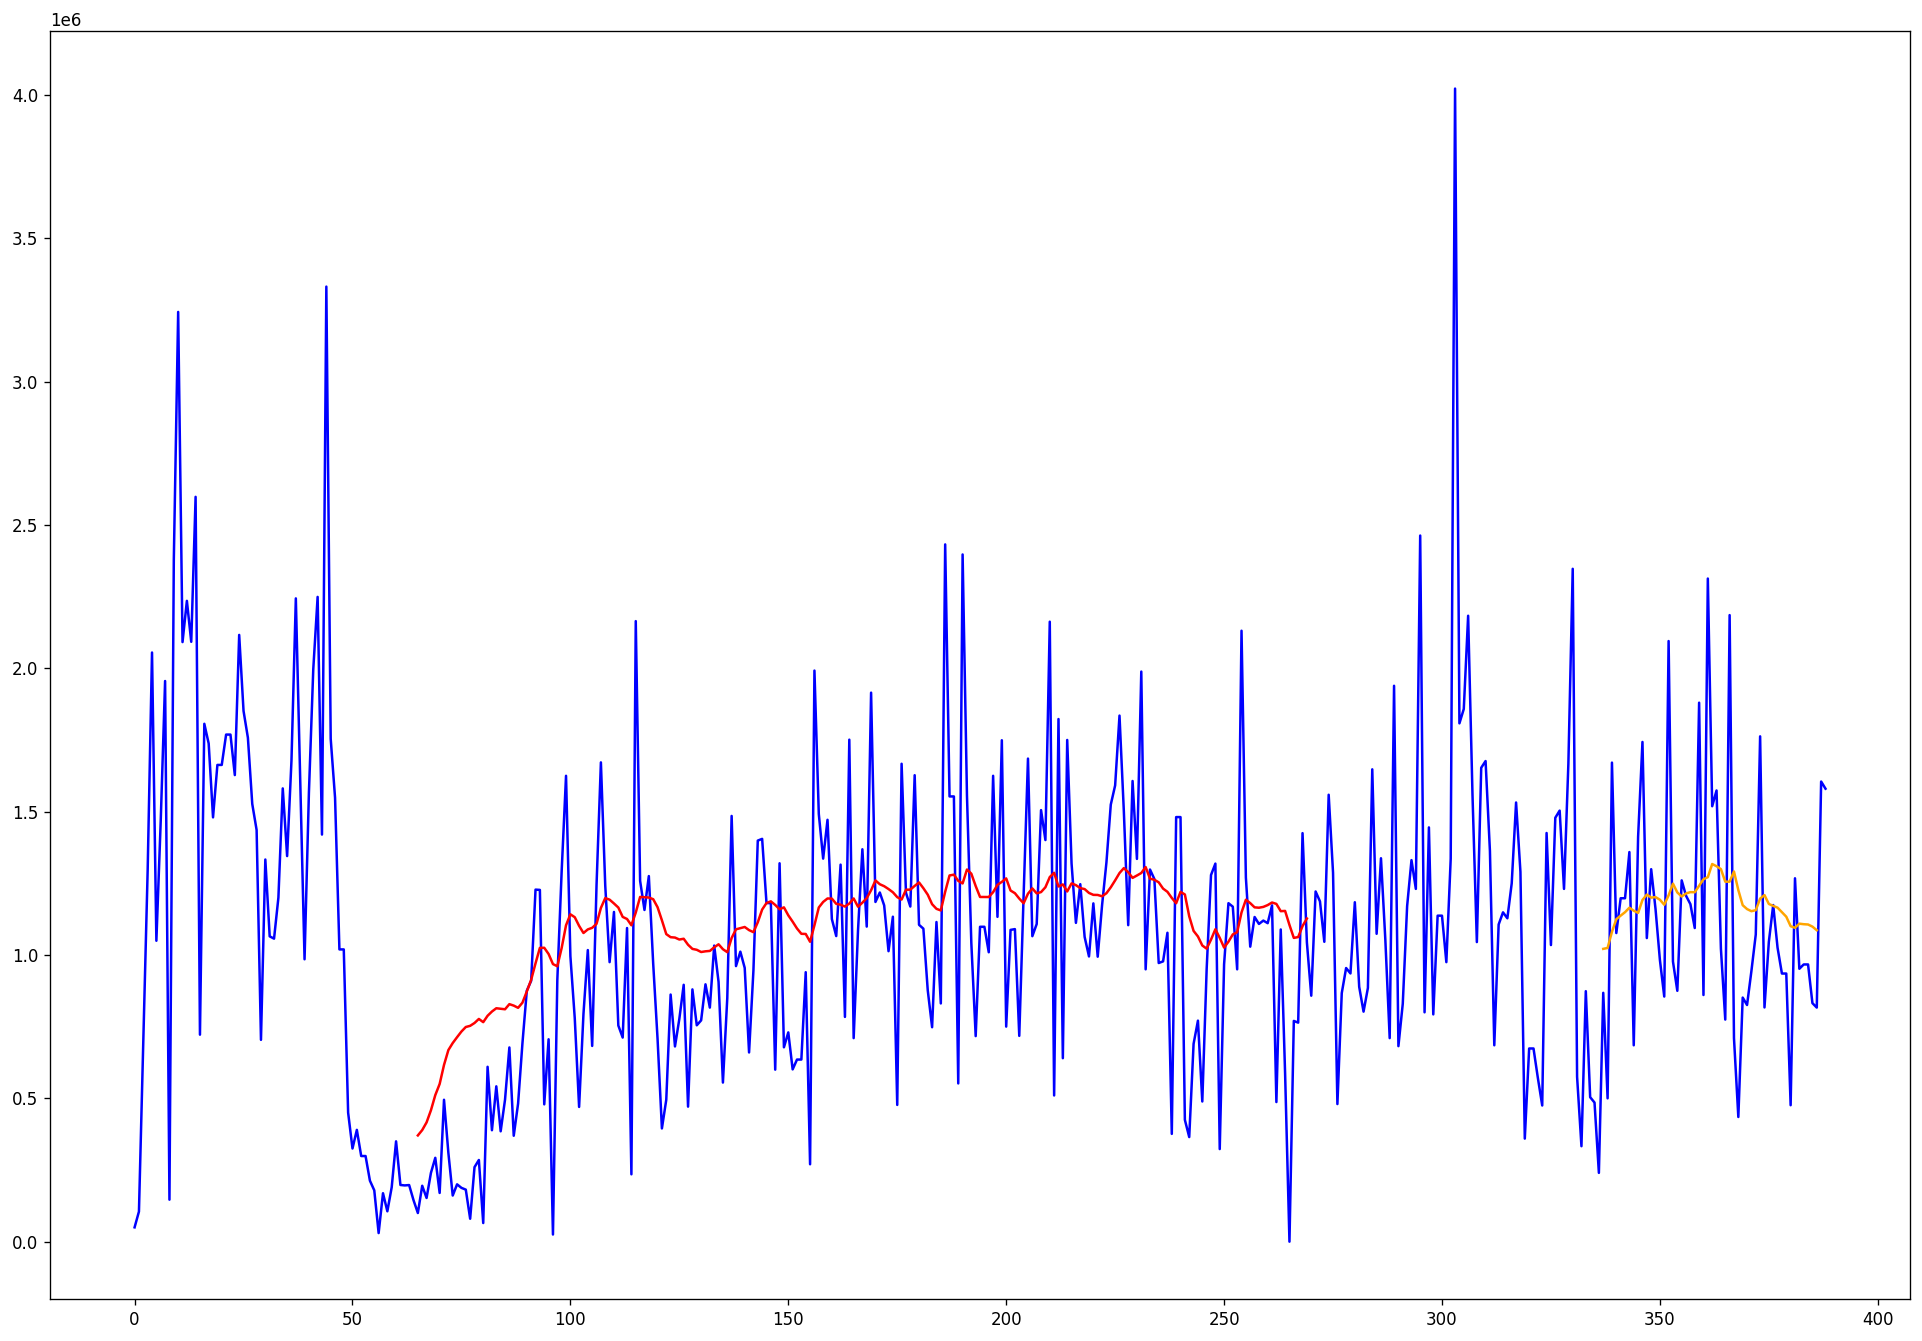

In [142]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot, color='r')
plt.plot(testPredictPlot, color='orange')
plt.show()

In [138]:
y_te = y_te.reshape(-1,1)

In [139]:
mean_absolute_percentage_error(testPredict, y_te)

0.27409496516139603